In [ ]:
import gymnasium as gym
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits import mplot3d
import time 
import math
from tqdm import tqdm

In [ ]:
env_name = 'CartPole-v1' 
env = gym.make(env_name, render_mode='rgb_array')   # for simulation
#env = gym.make(env_name, render_mode='human')       # for rendering 

In [ ]:
# let's experience with the environment  
observation, info = env.reset()
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

In [ ]:
# since the states that are composing the obsevation are all continous variables it is needed to discretize them 
# at first, we run a lot of episodes to identify the extrema in which the cart pole is behaving
obs_list = []
observation, info = env.reset()
obs_list.append(observation)

#here we are observaing a sequence of 10000 actions took, without considering the number of episode
for _ in range(2000):
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = env.step(action)
    obs_list.append(observation)
    if terminated or truncated:
       observation, info = env.reset()

In [ ]:
def intervals_split(start, finish, parts):
    part_duration = (finish-start) / parts
    return [start+i * part_duration for i in range(parts+1)]

In [ ]:
y = [0,1,2,3]

states = [[], [], [], []]

for k in range(len(obs_list)):
    plt.plot(obs_list[k][0], y[0], 'o', color='gray', alpha = 0.05)
    plt.plot(obs_list[k][1], y[1], 'o', color='gray', alpha = 0.05)
    plt.plot(obs_list[k][2], y[2], 'o', color='gray', alpha = 0.05)
    plt.plot(obs_list[k][3], y[3], 'o', color='gray', alpha = 0.05)
    states[0].append(obs_list[k][0])
    states[1].append(obs_list[k][1])
    states[2].append(obs_list[k][2])
    states[3].append(obs_list[k][3])
    
# took the extrema from the simulations 
extrema = []
intervals = []
n_split = [1,8,8,8]  # with 3 splits there are 5 intervals created, since two are that one that deal with +- infty

for k in range(len(states)):
    extrema.append([np.min(states[k]), np.max(states[k])])
    intervals.append(intervals_split(extrema[k][0], extrema[k][1], n_split[k]))

for k in range(len(states)):
    for i in range(len(intervals[k])):
        plt.plot(intervals[k][i], y[k], '|', color = 'red', markersize=5)
        

plt.show()

In [ ]:
def state_projection(value, intervals):
    
    discrete_state = []
    n_digits = []
    for k in range(len(list(value))):
        discrete_state.append(np.digitize(value[k], intervals[k])) # the k-th state description with the k-th intervals split
        n_digits.append(len(str(np.digitize(value[k], intervals[k]))))
    
    #print(discrete_state)
    # adding +2 since, for example, 3 splits will create 5 different intervals 
    discrete_state = discrete_state[0]+discrete_state[1]*(n_split[0]+2)+discrete_state[2]*(n_split[0]+2)*(n_split[1]+2)+discrete_state[3]*(n_split[0]+2)*(n_split[1]+2)*(n_split[2]+2)
    #print(discrete_state)
    
    return discrete_state

In [ ]:
Q_width = (n_split[0]+2)*(n_split[1]+2)*(n_split[2]+2)*(n_split[3]+2)
a = np.array([np.random.choice([0, 1], size=10, p=[.5, .5]), np.random.choice([0, 1], size=10, p=[.5, .5])])     
print(a)
print(a[:, 4])
print(np.argmax(a[:,4]))

In [483]:
plot_timestamps = []

class MC_learning():
    
    def __init__(self, intervals, n_split, env, epsilon = 0.98, gamma = 0.9):
        
        self.intervals = intervals
        self.epsilon = epsilon
        self.gamma = gamma
        self.env = env
        self.timestamps = []
        Q_height = 2 # since there are only two possible action 
        Q_width = (n_split[0]+2)*(n_split[1]+2)*(n_split[2]+2)*(n_split[3]+2)
        self.Q_table = np.array([np.random.choice([0, 1], size=Q_width, p=[.5, .5]), np.random.choice([0, 1], size=Q_width, p=[.5, .5])])        
        self.Counter_table = np.zeros_like(self.Q_table)
        
    def action_choice(self, state):
        
        rand_value = np.random.randint(0, 100+1)/100 
        if(rand_value > self.epsilon):
            action = int(np.random.choice([0, 1], size=1, p=[.5, .5]))
        else:
            action = np.argmax(self.Q_table[:, state]) 
        return action  
    
    def play_an_episode(self):
        
        obs_act_rew = []
        curr_state, info = env.reset()
        curr_state = state_projection(curr_state, self.intervals)
        index = 0
        episode_reward = []
        while(True):
            index +=1
            action = self.action_choice(curr_state)
            new_state, reward, terminated, truncated, info = env.step(action)
            episode_reward.append(reward)
            obs_act_rew.append([curr_state, action])
            curr_state = state_projection(new_state, self.intervals)
            
            if terminated or truncated:
                #print("episode last for {} timestemps".format(index))
                self.timestamps.append(index)
                
                for k in range(0,len(episode_reward),1):
                    if k == 0:
                        returns = episode_reward
                    else:
                        returns = list(reversed(episode_reward))[:-k]
                    obs_act_rew[k].append(math.fsum(returns))
                break
        
        return obs_act_rew    
    
    
    def update_Q_table(self, list_of_returns):
        
        G = 0
        for elem in list_of_returns[::-1]:
            state, action, reward = elem[0], elem[1], elem[2] 
            G = self.gamma*G + reward
            
            self.Counter_table[action][state] += 1
            a = self.Q_table[action][state]
            self.Q_table[action][state] = self.Q_table[action][state] + (1/self.Counter_table[action][state])*(G-self.Q_table[action][state])
            
        

In [524]:
MC_agent = MC_learning(intervals = intervals, n_split = n_split, env = env, epsilon=.90, gamma=1)
n_episode = 5000
for _ in tqdm(range(n_episode)):
    list_of_returns = MC_agent.play_an_episode()
    MC_agent.update_Q_table(list_of_returns)


100%|██████████| 5000/5000 [01:04<00:00, 78.08it/s] 


In [525]:
plot_timestamps.append(MC_agent.timestamps)

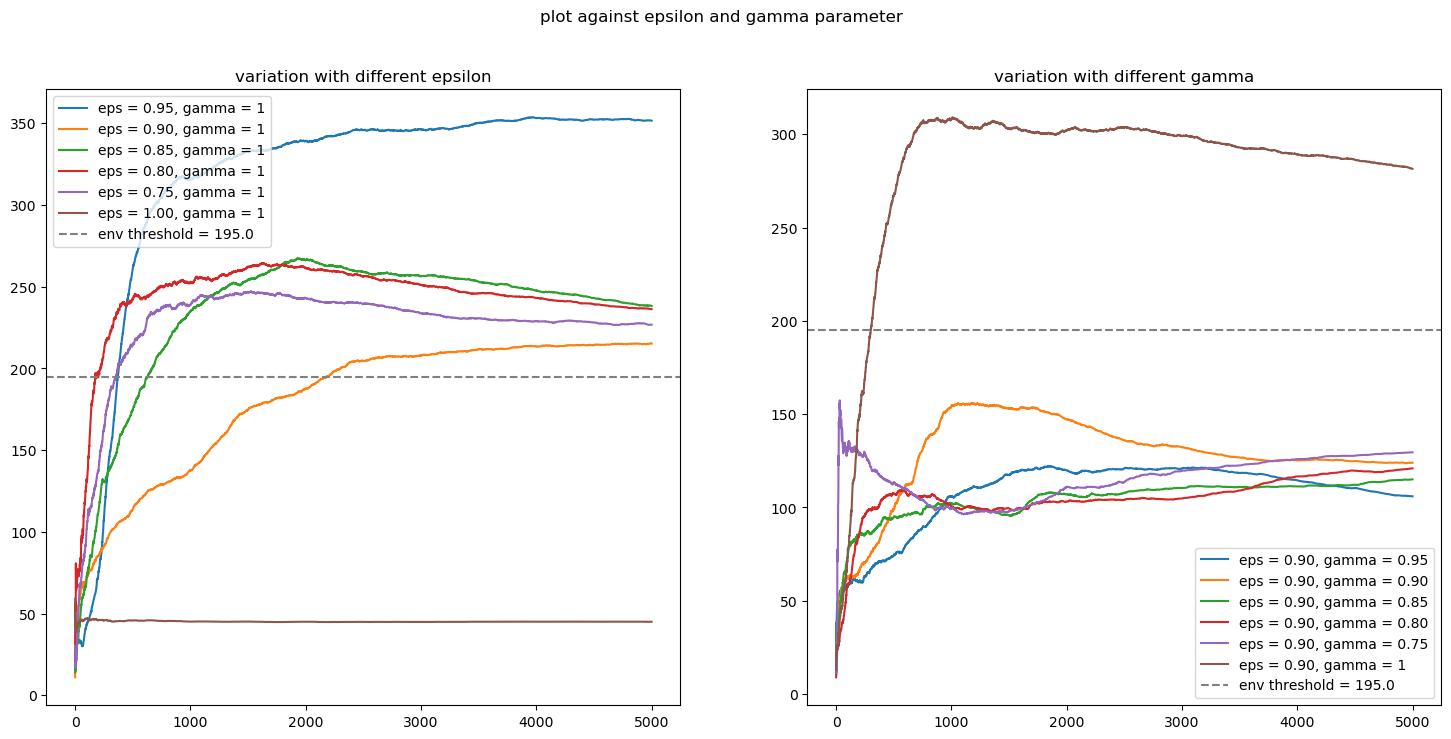

In [526]:
overall_timestamps = []

for k in range(len(plot_timestamps)):
    timestamps = plot_timestamps[k]
    accumul = 0
    mobile_avg = []
    counter = 0
    for elem in timestamps: 
        counter += 1
        accumul = accumul + (1/counter)*(elem-accumul) 
        mobile_avg.append(accumul)
    overall_timestamps.append(mobile_avg)

x = np.arange(len(overall_timestamps[0]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle('plot against epsilon and gamma parameter')
ax1.set_title("variation with different epsilon")
ax1.plot(x,overall_timestamps[0], label='eps = 0.95, gamma = 1')
ax1.plot(x,overall_timestamps[1], label='eps = 0.90, gamma = 1')
ax1.plot(x,overall_timestamps[2], label='eps = 0.85, gamma = 1')
ax1.plot(x,overall_timestamps[3], label='eps = 0.80, gamma = 1')
ax1.plot(x,overall_timestamps[4], label='eps = 0.75, gamma = 1')
ax1.plot(x,overall_timestamps[10], label='eps = 1.00, gamma = 1')
ax1.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
ax1.legend()

ax2.set_title("variation with different gamma")
ax2.plot(x,overall_timestamps[5], label='eps = 0.90, gamma = 0.95')
ax2.plot(x,overall_timestamps[6], label='eps = 0.90, gamma = 0.90')
ax2.plot(x,overall_timestamps[7], label='eps = 0.90, gamma = 0.85')
ax2.plot(x,overall_timestamps[8], label='eps = 0.90, gamma = 0.80')
ax2.plot(x,overall_timestamps[9], label='eps = 0.90, gamma = 0.75')
ax2.plot(x,overall_timestamps[11], label='eps = 0.90, gamma = 1')
ax2.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
ax2.legend()



In [528]:
env_name = 'CartPole-v1' 
#env = gym.make(env_name, render_mode='rgb_array')   # for simulation
env = gym.make(env_name, render_mode='human')       # for rendering

# let's experience with the environment  
observation, info = env.reset()
curr_state = state_projection(observation, MC_agent.intervals)
for _ in range(10000):
   
   action = MC_agent.action_choice(curr_state) 
   new_state, reward, terminated, truncated, info = env.step(action)
   curr_state = state_projection(new_state, MC_agent.intervals)

   if terminated or truncated:
      observation, info = env.reset() 

: 